In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pickle
from tqdm import tqdm
%matplotlib inline

In [2]:
class Interpolation:
    def __call__(self, img, py=32, px=32):
        sy = py / img.shape[0]
        sx = px / img.shape[1]
        return self.bilinear(img, sy, sx)
    
    def bilinear(self, img, sy=1.5, sx=1.5):
        H, W = img.shape[:2]
        ch = 1 if len(img.shape) < 3 else img.shape[2]
        H_big, W_big = int(H * sy), int(W * sx)
        output_img = np.zeros((H_big, W_big, ch))

        for i in range(H_big):
            for j in range(W_big):
                y, x = min(H-2, int(i/sy)), min(W-2, int(j/sx))
                dy, dx = i/sy - y, j/sx - x
                D = [(1-dy)*(1-dx), dy*(1-dx), (1-dy)*dx, dy*dx]
                if len(img.shape) == 3:
                    I = [img[y, x, :], img[y+1, x, :], img[y, x+1, :], img[y+1, x+1, :]]
                    output_img[i, j, :] = sum(d*z for (d, z) in zip(D, I))
                else:
                    I = [img[y, x], img[y+1, x], img[y, x+1], img[y+1, x+1]]
                    output_img[i, j] = sum(d*z for (d, z) in zip(D, I))

        # 仮に幅や高さが 1 になるような画像であると成立しないので注意
        output_img = np.squeeze(np.clip(output_img, 0, 255).astype("uint8"))
        return output_img

In [3]:
class HOGFeatureValue:        
    def quantize(self, value):
        res = np.floor(value / 20)
        if res >= 9: res = 8
        return res
    
    # reference solution は差分計算でオーバーフローをおこしていそう
    def calc_gx_gy(self, img):
        input_img = img.copy().astype(np.int32)
        H, W = input_img.shape
        gx = np.zeros_like(input_img).astype(np.int32)
        gy = np.zeros_like(input_img).astype(np.int32)
        for y in range(H):
            for x in range(W):
                gx[y, x] = input_img[y, min(x+1, W-1)] - input_img[y, max(x-1, 0)]
                gy[y, x] = input_img[min(y+1, H-1), x] - input_img[max(y-1, 0), x]
        return gx, gy
    
    def calc_mag_ang(self, gx, gy):
        H, W = gx.shape
        mag = np.zeros_like(gx, dtype=np.float32)
        ang = np.zeros_like(gy, dtype=np.float32)
        for y in range(H):
            for x in range(W):
                mag[y, x] = np.sqrt(gx[y, x]**2 + gy[y, x]**2)
                ang[y, x] = np.arctan2(gy[y, x], gx[y, x])
                if ang[y, x] < 0: ang[y, x] += np.pi
                ang[y, x] = self.quantize(ang[y, x] / np.pi * 180.0)
        ang = ang.astype(np.uint8)
        return mag, ang
                
    def get_colorized_ang(self, ang):
        color = [
            [255, 0, 0],
            [0, 255, 0],
            [0, 0, 255],
            [255, 255, 0],
            [255, 0, 255],
            [0, 255, 255],
            [127, 127, 0],
            [127, 0, 127],
            [0, 127, 127],
        ]
        H, W = ang.shape
        colorized_ang = np.zeros((H, W, 3), dtype=np.uint8)
        for i in range(9):
            colorized_ang[ang == i] = color[i]
        return colorized_ang
    
    # reference solution で x, y に掛ける数が 4 なのはおそらく間違い
    def gradient_histogram(self, mag, ang, N):
        H, W = mag.shape
        cell_H, cell_W = H // N, W // N
        histogram = np.zeros((cell_H, cell_W, 9), dtype=np.float32)
        
        for y in range(cell_H):
            for x in range(cell_W):
                for j in range(N):
                    for i in range(N):
                        histogram[y, x, ang[y*N+j, x*N+i]] += mag[y*N+j, x*N+i]
        return histogram
    
    def normalization(self, histogram, epsilon=1):
        cell_H, cell_W, _ = histogram.shape
        result_histogram = histogram.copy().astype(np.float32)
        for y in range(cell_H):
            for x in range(cell_W):
                result_histogram[y, x] /= np.sqrt(
                    np.sum(
                        histogram[max(y-1, 0):min(y+2, cell_H),
                                  max(x-1, 0):min(x+2, cell_W)]**2
                    ) + epsilon
                )
        return result_histogram
    
    def draw_feature_value(self, img_gray, histogram, N=8):
        H, W = img_gray.shape
        cell_H, cell_W, _ = histogram.shape
        
        output_img = img_gray.copy().astype(np.uint8)
        for y in range(cell_H):
            for x in range(cell_W):
                cx = x*N + N//2
                cy = y*N + N//2
                x1, y1, x2, y2 = cx + N//2 - 1, cy, cx - N//2 + 1, cy
                h = histogram[y, x] / np.sum(histogram[y, x])
                h /= h.max()
                
                for c in range(9):
                    theta = (20 * c + 10) / 180.0 * np.pi
                    rx = int(np.sin(theta)*(x1-cx) + np.cos(theta)*(y1-cy) + cx)
                    ry = int(np.cos(theta)*(x1-cx) - np.cos(theta)*(y1-cy) + cy)
                    lx = int(np.sin(theta)*(x2-cx) + np.cos(theta)*(y2-cy) + cx)
                    ly = int(np.cos(theta)*(x2-cx) - np.cos(theta)*(y2-cy) + cy)
                    color = int(255.0 * h[c])
                    cv2.line(output_img, (lx, ly), (rx, ry), (color, color, color))
        return output_img
    
    def get_hog_matrix(self, img, cell_size=8):
        if len(img.shape) == 3:
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        elif len(img.shape) == 2:
            img_gray = img.copy()
        else:
            assert False, "invlaid image dimension."

        gx, gy = self.calc_gx_gy(img_gray)
        mag, ang = self.calc_mag_ang(gx, gy)
        histogram = self.normalization(self.gradient_histogram(mag, ang, cell_size))
        return histogram

In [4]:
class Metrics:
    # rectangle: [y1, x1, y2, x2] (y1 <= y2, x1 <= x2)
    def iou(self, r1, r2):
        oy = max(0, min(r1[2], r2[2]) - max(r1[0], r2[0]))
        ox = max(0, min(r1[3], r2[3]) - max(r1[1], r2[1]))

        R1 = (r1[2] - r1[0]) * (r1[3] - r1[1])
        R2 = (r2[2] - r2[0]) * (r2[3] - r2[1])
        Rol = oy * ox
        return abs(Rol) / abs(R1 + R2 - Rol)
    
    def accuracy(self, num_of_samples, correct):
        return correct / num_of_samples

In [5]:
class LossFunction:
    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))

In [11]:
class MachineLearning:
    def __init__(self, seed=0):
        self.metrics = Metrics()
        np.random.seed(seed)
        
    def load_image(self, img_path):
        self.img = cv2.imread(img_path)
        assert len(self.img.shape) == 3, "invalid image dimension."
        self.H, self.W, self.C = self.img.shape
        
    def random_cropping(self, gt, samples=200, hsize=60, wsize=60):
        assert 0 < hsize <= self.H, "hsize value is invalid"
        assert 0 < wsize <= self.W, "wsize value is invalid"
        
        rectangles = np.zeros((samples, 4), dtype=np.float32)
        labels = np.zeros((samples), dtype=np.uint8)
        for i in range(samples):
            w = np.random.randint(self.W - wsize)
            h = np.random.randint(self.H - hsize)
            rectangles[i] = np.array((h, w, h+hsize, w+wsize))
            labels[i] = int(self.metrics.iou(gt, rectangles[i]) >= 0.5)
        return rectangles, labels
        
    def add_rectangles(self, rectangles, labels, gt=None):
        output_img = self.img.copy()
        colors = [
            (255, 0, 0),  # blue : not close
            (0, 255, 0),  # green: ground truth
            (0, 0, 255,)  # red  : close
        ]
        for rect, label in zip(rectangles, labels):
            y1, x1, y2, x2 = rect.astype(np.int)
            c = colors[label * 2]
            output_img = cv2.rectangle(output_img, (x1, y1), (x2, y2), c)
        if gt is not None:
            y1, x1, y2, x2 = gt.astype(np.int)
            c = colors[1]
            output_img = cv2.rectangle(output_img, (x1, y1), (x2, y2), c)
        return output_img
    
    def non_maximum_suppression(self, boxes, threshold=0.25):
        cur_boxes = boxes[np.argsort(boxes[:, -1])[::-1]]
        result_boxes = np.ndarray((0, 5), dtype=np.float32)
        while len(cur_boxes) > 0:
            b0 = cur_boxes[0]
            result_boxes = np.vstack([result_boxes, b0])
            new_boxes = np.ndarray((0, 5), dtype=np.float32)
            for i in range(1, len(cur_boxes)):
                if self.metrics.iou(b0[:4], cur_boxes[i, :4]) < threshold:
                    new_boxes = np.vstack([new_boxes, cur_boxes[i]])
            cur_boxes = new_boxes
        return result_boxes

In [7]:
class NeuralNetwork:
    def __init__(self, in_dim=2, w1=64, w2=64, out_dim=1, lr=0.1, seed=-1):
        if seed >= 0:
            np.random.seed(seed)
        self.w1 = np.random.normal(0, 1, [in_dim, w1])
        self.b1 = np.random.normal(0, 1, [w1])
        self.w2 = np.random.normal(0, 1, [w1, w2])
        self.b2 = np.random.normal(0, 1, [w2])
        self.wout = np.random.normal(0, 1, [w2, out_dim])
        self.bout = np.random.normal(0, 1, [out_dim])
        self.lr = lr
        self.loss_func = LossFunction()
        self.metrics = Metrics()
        
    def forward(self, x):
        self.z1 = x
        self.z2 = self.loss_func.sigmoid(np.dot(self.z1, self.w1) + self.b1)
        self.z3 = self.loss_func.sigmoid(np.dot(self.z2, self.w2) + self.b2)
        self.out = self.loss_func.sigmoid(np.dot(self.z3, self.wout) + self.bout)
        return self.out
    
    def back_propagation(self, x, t):
        En = (self.out - t) * self.out * (1 - self.out)
        grad_En = En
        grad_wout = np.dot(self.z3.T, En)
        grad_bout = np.dot(np.ones([En.shape[0]]), En)
        self.wout -= self.lr * grad_wout
        self.bout -= self.lr * grad_bout
        
        grad_u2 = np.dot(En, self.wout.T) * self.z3 * (1 - self.z3)
        grad_w2 = np.dot(self.z2.T, grad_u2)
        grad_b2 = np.dot(np.ones([grad_u2.shape[0]]), grad_u2)
        self.w2 -= self.lr * grad_w2
        self.b2 -= self.lr * grad_b2
        
        grad_u1 = np.dot(grad_u2, self.w2.T) * self.z2 * (1 - self.z2)
        grad_w1 = np.dot(self.z1.T, grad_u1)
        grad_b1 = np.dot(np.ones([grad_u1.shape[0]]), grad_u1)
        self.w1 -= self.lr * grad_w1
        self.b1 -= self.lr * grad_b1
        
    def train(self, train_x, train_t, iteration=5000):
        for i in tqdm(range(iteration)):
            self.forward(train_x)
            self.back_propagation(train_x, train_t)
            
    def evaluate(self, test_x, test_t, show_rawvalue=False):
        num_of_samples, correct = test_x.shape[0], 0
        for i in range(num_of_samples):
            pred = self.forward(test_x[i])
            raw_pred = pred.copy()
            if show_rawvalue:
                print("data {}: {:.6f}".format(i+1, raw_pred[0]))
            pred[0] = 1 if pred[0] >= 0.5 else 0
            if np.array_equal(pred, test_t[i]):
                correct += 1
            else:
                print("[!] wrong: pred {} (raw: {}), test {}".format(pred, raw_pred, test_t[i]))
        evaluate_result = {
            "num_of_samples": num_of_samples,
            "num_of_correct": correct,
            "accuracy": self.metrics.accuracy(num_of_samples, correct)
        }
        return evaluate_result

In [8]:
class DataUtility:
    def save_data(self, obj, file_name):
        with open(file_name, mode="wb") as f:
            pickle.dump(obj, f)
        
    def load_data(self, file_name):
        if not pathlib.Path(file_name).exists():
            return None
        with open(file_name, mode="rb") as f:
            return pickle.load(f)

In [26]:
class Solver:
    def __init__(self, seed=0):
        self.ml = MachineLearning(seed=seed)
        self.hog = HOGFeatureValue()
        self.resize = Interpolation()
        self.data_util = DataUtility()
        
        self.model_name = "model.pkl"
        self.test_data_name = "test_data.pkl"
        self.boxes_name = "boxes.pkl"
        self.answer_boxes_name = "answer_boxes.pkl"
        
        self.model = self.data_util.load_data(self.model_name)
        self.test_data = self.data_util.load_data(self.test_data_name)
        self.boxes = self.data_util.load_data(self.boxes_name)
        
    def get_bounding_boxes(self, img, stride=4):
        recs = np.array(((42, 42), (56, 56), (70, 70)), dtype=np.float32)
        H, W = img.shape[:2]
        
        num_boxes = ((H+stride-1)//stride) * ((W+stride-1)//stride) * recs.shape[0]
        boxes = np.zeros((num_boxes, 4))
        i = 0
        for y in range(0, H, stride):
            for x in range(0, W, stride):
                for dy, dx in recs:
                    y1, x1 = y, x
                    y2, x2 = min(H-1, y+dy), min(W-1, x+dx)
                    boxes[i] = np.array([y1, x1, y2, x2])
                    i += 1
        return boxes
    
    def get_hog_matrices(self, img, boxes, img_size=32, cell_size=8):
        vec_size = (img_size//cell_size)**2 * 9
        data = np.zeros((boxes.shape[0], vec_size), dtype=np.float32)
        for i, box in enumerate(tqdm(boxes)):
            y1, x1, y2, x2 = box.astype(np.int)
            resized_img = self.resize(img[y1:y2, x1:x2], img_size, img_size)
            data[i] = self.hog.get_hog_matrix(resized_img, cell_size).ravel().astype(np.float32)
        return data
    
    def get_test_data(self, img, stride=4, img_size=32, cell_size=8):
        boxes = self.get_bounding_boxes(img, stride)
        test_data = self.get_hog_matrices(img, boxes, img_size, cell_size)
        return test_data, boxes
    
    def train_model(self, img_path, samples=200, img_size=32, cell_size=8, lr=0.01, seed=0):
        self.ml.load_image(img_path)
        gt = np.array([41, 47, 103, 129], dtype=np.float32)
        
        rects, labels = self.ml.random_cropping(
            gt,
            samples=samples,
            hsize=60,
            wsize=60
        )
        labels = labels[:, np.newaxis]
        
        vec_size = (img_size//cell_size) * (img_size//cell_size) * 9
        data = np.zeros((samples, vec_size), dtype=np.float32)
        for i, rect in enumerate(rects):
            y1, x1, y2, x2 = rect.astype(np.int)
            resized_img = self.resize(self.ml.img[y1:y2, x1:x2])
            hist = self.hog.get_hog_matrix(
                resized_img,
                cell_size=cell_size
            ).ravel()
            data[i] = hist.astype(np.float32)
        
        print(data.shape, labels.shape)
        print("label: # or [0, 1] = [{}, {}]".format(
                np.size(labels) - np.sum(labels),
                np.sum(labels),
            )
        )
        nn = NeuralNetwork(in_dim=data.shape[1], out_dim=1, seed=seed, lr=lr)
        nn.train(data, labels, 10000)
        evaluate_result = nn.evaluate(data, labels)
        print("Accuracy >> {} ({} / {})".format(
                evaluate_result["accuracy"],
                evaluate_result["num_of_correct"],
                evaluate_result["num_of_samples"],
            )
        )
        return nn
        
    def problem_97(self, img_path):
        input_img = cv2.imread(img_path)
        # stride = 4 だと 5 分掛かるので妥協。並列化したらマシになるかもしれないけど
        train_data = self.get_test_data(input_img, stride=8)
        
    def problem_98(self, imori_single_path, imori_many_path):
        if self.model is None:
            self.model = self.train_model(imori_single_path)
            self.data_util.save_data(self.model, self.model_name)

        input_img = cv2.imread(imori_many_path)
        if self.test_data is None or self.boxes is None:
            self.test_data, self.boxes = self.get_test_data(input_img, stride=4)
            self.data_util.save_data(self.test_data, self.test_data_name)
            self.data_util.save_data(self.boxes, self.boxes_name)
        print(self.test_data.shape)
        output_img = input_img.copy()
        answer_boxes = []
        for i, in_data in enumerate(self.test_data):
            pred_data = self.model.forward(in_data)
            if pred_data[0] >= 0.7:
                y1, x1, y2, x2 = self.boxes[i].astype(np.int)
                red = (0, 0, 255)
                answer_boxes.append(np.concatenate([self.boxes[i], pred_data]))
                output_img = cv2.rectangle(output_img, (x1, y1), (x2, y2), red)
        answer_boxes = np.array(answer_boxes)
        self.data_util.save_data(answer_boxes, self.answer_boxes_name)
        return output_img
    
    def problem_99(self, imori_single_path, imori_many_path):
        if self.model is None:
            self.model = self.train_model(imori_single_path)
            self.data_util.save_data(self.model, self.model_name)

        input_img = cv2.imread(imori_many_path)
        if self.test_data is None or self.boxes is None:
            self.test_data, self.boxes = self.get_test_data(input_img, stride=4)
            self.data_util.save_data(self.test_data, self.test_data_name)
            self.data_util.save_data(self.boxes, self.boxes_name)
        print(self.test_data.shape)
        
        answer_boxes = []
        for i, in_data in enumerate(self.test_data):
            pred_data = self.model.forward(in_data)
            if pred_data[0] >= 0.7:
                y1, x1, y2, x2 = self.boxes[i].astype(np.int)
                answer_boxes.append(np.concatenate([self.boxes[i], pred_data]))
        answer_boxes = np.array(answer_boxes)
        answer_boxes = self.ml.non_maximum_suppression(answer_boxes)
        self.data_util.save_data(answer_boxes, self.answer_boxes_name)
        
        output_img = input_img.copy()
        for box in answer_boxes:
            y1, x1, y2, x2 = box[:4].astype(np.int)
            value = "{:.2f}".format(box[4].astype(np.float32))
            red = (0, 0, 255)
            output_img = cv2.rectangle(output_img, (x1, y1), (x2, y2), red)
            output_img = cv2.putText(
                output_img,
                value,
                (x1, y2),
                cv2.FONT_HERSHEY_PLAIN,
                1,
                (255, 0, 255),
                1,
                cv2.LINE_AA
            )
        return output_img

(6912, 144)


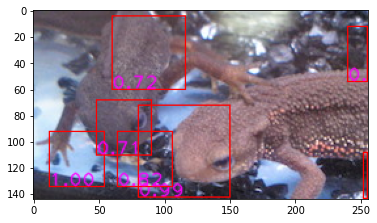

In [27]:
solver = Solver()
output_img = solver.problem_99("../imori_1.jpg", "../imori_many.jpg")
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.show()